# Base Notebook (CP-ML)

#### Contents

* [Data and Preprocessing](#Data-and-Preprocessing)
* [Visualization](#Visualization)
* [Processing and Feature Engineering](#Processing-and-Feature-Engineering)
* [Models, Cross-Validation and Tuning](#Models,-Cross-Validation-and-Tuning)
* [Model Evaluation](#Model-Evaluation)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

In [2]:
import os
import glob

In [3]:
from cp import CIFParser, PDBParser, StructureParser
from mpl_toolkits.mplot3d import Axes3D

*Set seed for reproducibility*

In [4]:
np.random.seed(42)

## Data and Preprocessing
**[&uarr; Return to Contents](#Contents)**

In [5]:
data_d0 = 'E:/ic-exp-uobs/dens-035/'

In [6]:
cifs = np.array(glob.glob(os.path.join(data_d0, '*.cif')))
pdbs = np.array(glob.glob(os.path.join(data_d0, '*.pdb')))

In [7]:
def parse_multiple_structures(cif_list, pdb_list):
    multiple_struct_df = pd.DataFrame()
    for cif, pdb in zip(cif_list, pdb_list):
        structure = StructureParser(cif, pdb)
        structure.parse()
        multiple_struct_df = multiple_struct_df.append(structure.structure_df(pdb_id=True))
    return multiple_struct_df

In [8]:
def sample_files(n_structures, cif_list, pdb_list):
    permuted_indexes = np.random.permutation(len(cif_list))
    sampled_cifs = cif_list[permuted_indexes][:n_structures]
    sampled_pdbs = pdb_list[permuted_indexes][:n_structures]
    return sampled_cifs, sampled_pdbs

In [9]:
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

*Set sample size*

In [10]:
n_structures_sample = 5

In [11]:
cif_sample, pdb_sample = sample_files(n_structures_sample, cifs, pdbs)

In [12]:
full_df = parse_multiple_structures(cif_sample, pdb_sample)

In [13]:
ms_df = reduce_mem_usage(full_df)

Memory usage of dataframe is 133.37 MB
Memory usage after optimization is: 30.22 MB
Decreased by 77.3%


In [14]:
ms_df['SIGUOBS'] = ms_df['UOBS']*ms_df['SIGFOBS']/ms_df['FOBS']

In [15]:
ms_df.shape

(546273, 31)

## Visualization
**[&uarr; Return to Contents](#Contents)**

In [16]:
dropped_columns = ['pdbx_r_free_flag', 'crystal_system',
                   'IT_number', 'name_H-M_alt', 'name_Hall', 'space_group_name_H-M',
                   'space_group_name_Hall', 'Int_Tables_number', 'SYNCHROTRON', 'WILSON']

In [17]:
ms_df_vis = ms_df.drop(dropped_columns, axis=1)

In [18]:
ms_df_vis['COSPHI'] = np.cos(ms_df_vis['PHI']*np.pi/180.0)

In [19]:
ms_df_vis['SINPHI'] = np.sin(ms_df_vis['PHI']*np.pi/180.0)

###  Histogram

In [20]:
ms_df_vis.columns

Index(['index_h', 'index_k', 'index_l', 'FOBS', 'SIGFOBS', 'UOBS', 'SIGUOBS',
       'FC', 'PHI', 'FOM', 'RESOL', 'length_a', 'length_b', 'length_c',
       'angle_alpha', 'angle_beta', 'angle_gamma', 'volume', 'SOLV',
       'MATTHEWS', 'ID', 'COSPHI', 'SINPHI'],
      dtype='object')

Dropped $\alpha$ (```angle_alpha```) because it is the first angle to be determined and follows the convention of being the straight angle (reference here).

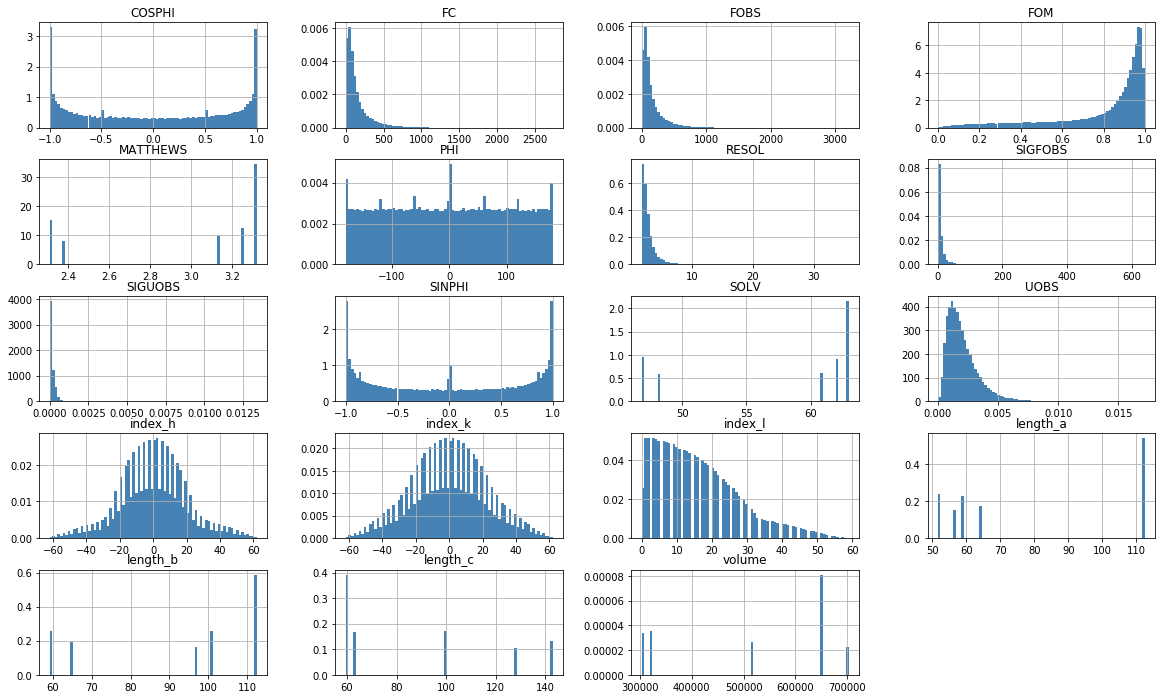

In [21]:
ms_df_vis.hist(figsize=(20,12), column=['index_h', 'index_k', 'index_l', 'FOBS', 'SIGFOBS', 'UOBS', 'SIGUOBS',
       'FC', 'PHI', 'FOM', 'RESOL', 'length_a', 'length_b', 'length_c',
       'volume', 'SOLV',
       'MATTHEWS', 'COSPHI', 'SINPHI'],
        color='steelblue', bins=80, density=True)
plt.show()

#### Conclusions

* Very different data scales (for instance, ```UOBS``` and ```VOLUME```)
* ```PHI``` has a very uniform distribution with spikes associated with centrosymmetric reflections. ```COSPHI``` may be better than ```PHI``` because it solves the problem of circular boundary conditions on ```PHI```, altough it is not sufficient to recover the angle (not invertible in $[-\pi, \pi]$). In this case, using a softmax layer may be a good idea.
* Many distributions are heavy-tailed. Binning may an alternative (*e.g.* classes of resolution quality).

### Probing pairwise correlations

In [22]:
corr_matrix = ms_df_vis.corr()

In [23]:
corr_attribs  = ['UOBS', 'SIGUOBS', 'FOBS', 'COSPHI', 'PHI']

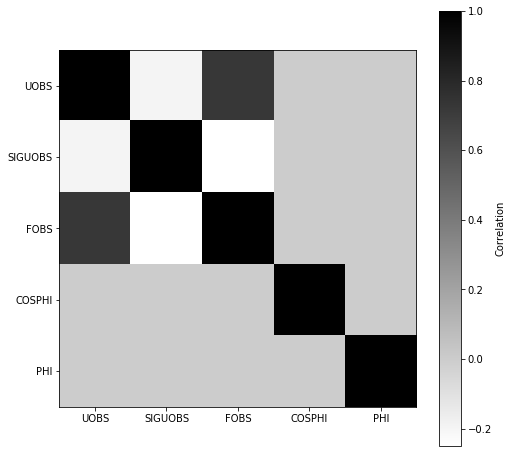

In [24]:
fig = plt.figure(figsize=(8,8))
plt.imshow(corr_matrix.loc[corr_attribs, corr_attribs].values, cmap=plt.cm.gray_r)
plt.colorbar(label='Correlation')
ax = plt.gca()
plt.xticks(np.arange(0, 5), corr_attribs)
plt.yticks(np.arange(0, 5), corr_attribs)
plt.show()

In [25]:
full_attribs = list(corr_matrix.columns)

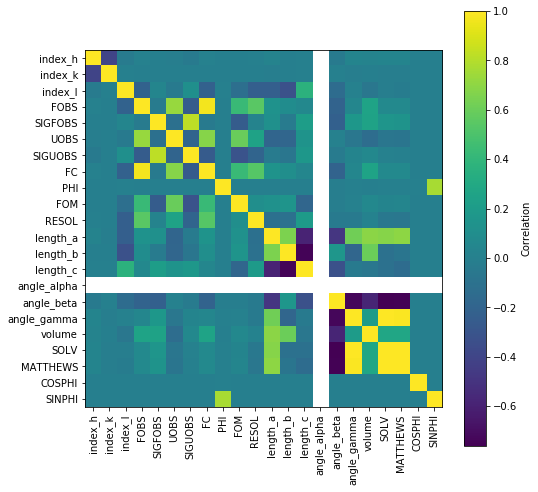

In [26]:
fig = plt.figure(figsize=(8,8))
plt.imshow(corr_matrix.values, cmap=plt.cm.viridis)
plt.colorbar(label='Correlation')
ax = plt.gca()
plt.xticks(np.arange(len(full_attribs)), full_attribs, rotation='vertical')
plt.yticks(np.arange(len(full_attribs)), full_attribs)
plt.show()

### Probing correlations in 3 dimensions

In [27]:
sampling_rate = 200

In [28]:
norm = plt.Normalize(vmin=-1, vmax=1)

In [29]:
mask = np.logical_and(ms_df_vis['RESOL'][::sampling_rate] < 4, (ms_df_vis['UOBS'][::sampling_rate] < 0.015))

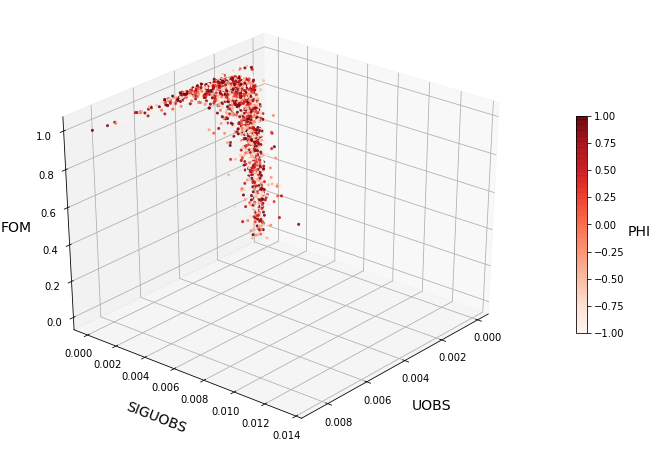

In [30]:
fig = plt.figure(figsize=(12,8))
ax = fig.gca(projection='3d')
sc = ax.scatter(ms_df_vis['UOBS'][::sampling_rate][mask], ms_df_vis['SIGUOBS'][::sampling_rate][mask],
                ms_df_vis['FOM'][::sampling_rate][mask],
                'o',  c=ms_df_vis['COSPHI'][::sampling_rate][mask], 
                norm=norm, cmap=plt.cm.Reds,  s=4 , alpha=0.8)
ax.set_xlabel('UOBS', labelpad=15, fontsize=14)
ax.set_ylabel('SIGUOBS',labelpad=15, fontsize=14)
ax.set_zlabel('FOM', labelpad=10, fontsize=14)
cbar = plt.colorbar(sc, ax=ax, shrink=0.5, label='PHI')
cbar.set_label(label='PHI', fontsize=14, labelpad=14, rotation='horizontal')
ax.view_init(30, 40)
plt.show()


## Processing and Feature Engineering
**[&uarr; Return to Contents](#Contents)**

In [31]:
from sklearn.pipeline import Pipeline

### Train and Test Sets

In [32]:
from sklearn.model_selection import train_test_split

In [33]:
base_df = ms_df_vis.copy()

In [34]:
train_set, test_set = train_test_split(base_df, test_size=0.2, random_state=42)

In [35]:
X_train, y_train = train_set.drop(['COSPHI', 'SINPHI', 'PHI', 'ID', 'FC'], axis=1), train_set['PHI']
X_test, y_test = test_set.drop(['COSPHI', 'SINPHI', 'PHI', 'ID', 'FC'], axis=1), test_set['PHI']

#### Processing indexes

In [36]:
from sklearn.base import BaseEstimator, TransformerMixin

In [37]:
class MillerIndexesEncoder(BaseEstimator, TransformerMixin):
    
    def __init__(self, encoding='planar',
                 indexes=['index_h', 'index_k', 'index_l'],
                 axes=['length_a', 'length_b', 'length_c'], 
                 angles=['THETA', 'VARPHI']):
        self.encoding = encoding
        self.indexes = indexes
        self.axes = axes
        self.angles = angles
        
    def _planar_enc(self, X, y=None):
        temp_df = X.copy()
        other_df = X.copy()
        for index, ax in zip(self.indexes, self.axes):
            plane_name = 'plane_'+ index[-1]
            temp_df.loc[X[index] == 0, index] = np.inf
            other_df[plane_name] = temp_df[ax]/temp_df[index]
        return other_df
        
    def _angular_enc(self, X, y=None):
        temp_df = X.copy()
        h, k, l = X['index_h'].astype(np.int64), X['index_k'].astype(np.int64), X['index_l'].astype(np.int64)
        temp_df[self.angles[0]] = np.arctan2(X['index_k'], X['index_h']) * 180.0/np.pi
        temp_df[self.angles[1]] = np.arccos(X['index_l']/np.sqrt(h**2+k**2+l**2)) * 180.0/np.pi
        return temp_df
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if self.encoding == 'planar':
            return self._planar_enc(X)
        
        if self.encoding == 'angular':
            return self._angular_enc(X)
        
        if self.encoding == 'both':
            temp = self._planar_enc(X)
            return self._angular_enc(temp)
        

#### Preparing Labels

In [38]:
from sklearn.preprocessing import MinMaxScaler

In [39]:
class AngleEncoder(BaseEstimator, TransformerMixin):
    
    def __init__(self, encoding='sin_cos', interval=(-1,1)):
        self.encoding = encoding
        self.interval = interval
        
    def _sin_cos_encoding(self, X):
        X_rad = X.copy()*np.pi/180.0
        return (np.cos(X_rad), np.sin(X_rad))
    
    def _linearly_scaled_encoding(self, X):
        scaler = MinMaxScaler(self.interval)
        X_scaled = scaler.fit_transform(X.reshape(-1,1)).flatten()
        return X_scaled

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        if self.encoding == 'sin_cos':
            return self._sin_cos_encoding(X)
        
        if self.encoding == 'linearly_scaled':
            return self._linearly_scaled_encoding(X)

#### Processing Pipeline

In [40]:
from sklearn.preprocessing import RobustScaler, StandardScaler

In [41]:
features_processing_pipeline = Pipeline([
    ('miller_indexes_encoder', MillerIndexesEncoder(encoding='both')),
    ('scaling', StandardScaler())
])

In [42]:
labels_processing_pipeline = Pipeline([
    ('angle_encoder', AngleEncoder(encoding='linearly_scaled', interval=(-1,1)))
])

## Models, Cross-Validation and Tuning
**[&uarr; Return to Contents](#Contents)**

In [43]:
vis_sampling = 1000

#### Feature Selection

In [44]:
class SelectKTopFeatures(BaseEstimator, TransformerMixin):
    
    def __init__(self, feature_importances=None, k=5):
        self.k = k 
        self.feature_importances = feature_importances
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        sorting_indexes = np.argsort(self.feature_importances)[::-1]
        X_k_features = X[:, sorting_indexes[:self.k]]
        return X_k_features
        

#### Feature Drop

In [45]:
class DropFeatures(BaseEstimator, TransformerMixin):
    
    def __init__(self, features_to_drop=['index_h', 'index_k', 'index_l']):
        self.features_to_drop = features_to_drop
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X_new = X.drop(self.features_to_drop, axis=1)
        return X_new
        

### XGBoost

In [46]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

##### Cross-Validation

In [78]:
xgb_pipeline = Pipeline([
    ('miller_indexes_encoder', MillerIndexesEncoder(encoding='both')),
    ('droper', DropFeatures()),
    ('feature_scaling', StandardScaler()),
    ('xgb', xgb.sklearn.XGBRegressor())
])

In [79]:
param_grid_xgb = [  
    {
        'miller_indexes_encoder__encoding':['both'], 
        'feature_scaling':[RobustScaler()], 
        'xgb__min_child_weight':[0.5],
        'xgb__max_depth':[20],
        'xgb__n_estimators':[100],
        'xgb__alpha':[10],
    }
]

In [80]:
xgb_rcv = GridSearchCV(xgb_pipeline, param_grid_xgb, n_jobs=-1, cv=3,
                            scoring='neg_mean_squared_error')

In [81]:
xgb_rcv.fit(X_train, y_train)

[10:24:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('miller_indexes_encoder',
                                        MillerIndexesEncoder(angles=['THETA',
                                                                     'VARPHI'],
                                                             axes=['length_a',
                                                                   'length_b',
                                                                   'length_c'],
                                                             encoding='both',
                                                             indexes=['index_h',
                                                                      'index_k',
                                                                      'index_l'])),
                                       ('droper',
                                        DropFeatures(features_to_drop=['index_h',
 

In [83]:
xgb_rcv.best_estimator_.named_steps.xgb

XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=20, min_child_weight=0.5, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [71]:
predictions = xgb_rcv.predict(X_test)

NameError: name 'xgb_rcv' is not defined

In [ ]:
plt.plot(predictions[::vis_sampling],  'o', markersize=4, color='mediumvioletred')
plt.plot(y_train[::vis_sampling].values, 'o',color='forestgreen')
plt.show()

*Save your results!*

```python
from joblib import dump
dump(model, filename)
```

In [86]:
from joblib import dump

**Feature importances**

In [88]:
from xgboost import plot_importance

In [89]:
xgb_rcv.best_estimator_.named_steps.xgb

XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=20, min_child_weight=0.5, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [90]:
xgb_rcb_bes_fi = xgb_rcv.best_estimator_.named_steps.xgb.feature_importances_

In [91]:
x_coord = range(0, len(xgb_rcb_bes_fi))

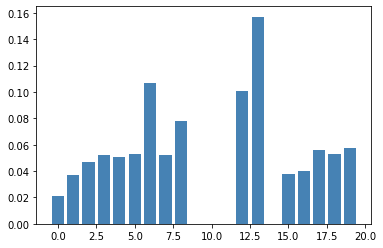

In [92]:
plt.bar(x_coord,xgb_rcb_bes_fi, color='steelblue', )
plt.show()

##### Using feature selection

In [121]:
xgb_pipeline_feature_selection = Pipeline([
    ('miller_indexes_encoder', MillerIndexesEncoder(encoding='both')),
    ('droper', DropFeatures()),
    ('feature_scaling', StandardScaler()),
    ('feature_selection', SelectKTopFeatures()),
    ('xgb', xgb.sklearn.XGBRegressor())
])

In [122]:
param_grid_xgb_fs = [  
    {
        'miller_indexes_encoder__encoding':['both'],
        'feature_scaling':[RobustScaler()], 
        'feature_selection__k':[15, 10, 5],
        'feature_selection__feature_importances':[xgb_rcb_bes_fi],
        'xgb__min_child_weight':[0.5],
        'xgb__max_depth':[20],
        'xgb__n_estimators':[80],
        'xgb__alpha':[10],
    }
]

In [123]:
xgb_rcv_feature_selection = GridSearchCV(xgb_pipeline_feature_selection, param_grid_xgb_fs, cv=3,
                                               scoring='neg_mean_squared_error', n_jobs=-1)

In [124]:
xgb_rcv_feature_selection.fit(X_train, y_train)

[10:49:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('miller_indexes_encoder',
                                        MillerIndexesEncoder(angles=['THETA',
                                                                     'VARPHI'],
                                                             axes=['length_a',
                                                                   'length_b',
                                                                   'length_c'],
                                                             encoding='both',
                                                             indexes=['index_h',
                                                                      'index_k',
                                                                      'index_l'])),
                                       ('droper',
                                        DropFeatures(features_to_drop=['index_h',
 

In [129]:
xgb_rcv_feature_selection.best_estimator_.named_steps.feature_selection

SelectKTopFeatures(feature_importances=array([0.02112637, 0.0370331 , 0.04672682, 0.05195872, 0.05030775,
       0.05307007, 0.10664017, 0.05229441, 0.07821207, 0.        ,
       0.        , 0.        , 0.10089538, 0.15709169, 0.        ,
       0.0381563 , 0.04019614, 0.05622673, 0.05284693, 0.05721734],
      dtype=float32),
                   k=5)

In [130]:
xgb_rcv_feature_selection.best_estimator_.named_steps.xgb

XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=20, min_child_weight=0.5, missing=None, n_estimators=80,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [133]:
predictions_xgb_fs = xgb_rcv_feature_selection.predict(X_test)

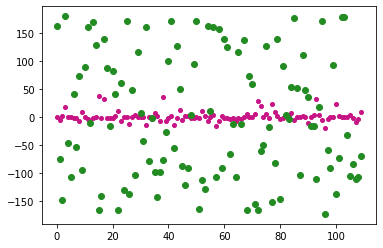

In [134]:
plt.plot(predictions_xgb_fs[::vis_sampling],  'o', markersize=4, color='mediumvioletred')
plt.plot(y_test.values[::vis_sampling], 'o',color='forestgreen')
plt.show()

###  Deep Neural Network (linearly scaled)

Using TensorFlow low-level API to train a Feed-Forward Network. 

In [47]:
import tensorflow as tf
from tensorflow.contrib.layers import fully_connected

#### Data Prep

In [48]:
X_train.columns

Index(['index_h', 'index_k', 'index_l', 'FOBS', 'SIGFOBS', 'UOBS', 'SIGUOBS',
       'FOM', 'RESOL', 'length_a', 'length_b', 'length_c', 'angle_alpha',
       'angle_beta', 'angle_gamma', 'volume', 'SOLV', 'MATTHEWS'],
      dtype='object')

In [49]:
nn1_features_processing = features_processing_pipeline.set_params(miller_indexes_encoder__encoding='both')

In [50]:
nn1_features_processing

Pipeline(memory=None,
         steps=[('miller_indexes_encoder',
                 MillerIndexesEncoder(angles=['THETA', 'VARPHI'],
                                      axes=['length_a', 'length_b', 'length_c'],
                                      encoding='both',
                                      indexes=['index_h', 'index_k',
                                               'index_l'])),
                ('scaling',
                 StandardScaler(copy=True, with_mean=True, with_std=True))],
         verbose=False)

In [51]:
nn1_labels_processing = labels_processing_pipeline.set_params(angle_encoder__encoding='linearly_scaled', angle_encoder__interval=(-1, 1))

In [52]:
X_train_dnn = nn1_features_processing.fit_transform(X_train)

In [53]:
y_train_dnn = nn1_labels_processing.fit_transform(y_train.values)

In [54]:
def batch_generator(X, y, epoch, batch_index, batch_size):
    np.random.seed(epoch*batch_size+batch_index)
    indexes = np.random.randint(m, size=batch_size)
    X_shuffled, y_shuffled = X[indexes], y[indexes]
    return X_shuffled, y_shuffled    

#### Building

In [285]:
tf.reset_default_graph()

In [289]:
n_hidden1 = 300
n_hidden2 = 50

In [290]:
m, input_length = X_train_dnn.shape

In [291]:
n_outputs=1

In [292]:
with tf.name_scope('placeholders'):
    X = tf.placeholder(tf.float32, shape=(None, input_length), name='X')
    y = tf.placeholder(tf.float32, shape=(None), name='y')

In [293]:
with tf.name_scope('dnn'):
    hidden1 = fully_connected(X, n_hidden1, scope='hidden1')
    hidden2 = fully_connected(hidden1, n_hidden2, scope='hidden2')
    logits = fully_connected(hidden2, n_outputs, activation_fn=None, scope='outputs')

In [294]:
with tf.name_scope('loss'):
    squared_error = tf.square(logits-y)
    loss = tf.reduce_mean(squared_error)

In [295]:
with tf.name_scope('train'):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=1e-4)
    training_op = optimizer.minimize(loss)

In [296]:
with tf.name_scope('eval'):
    sqrt_mse = tf.sqrt(loss)

In [297]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

#### Training

In [321]:
n_epochs = 100
batch_size = 10

In [322]:
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(m//batch_size):
            X_batch, y_batch = batch_generator(X_train_dnn, y_train_dnn, epoch, iteration, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        train_score = sqrt_mse.eval(feed_dict={X: X_batch, y: y_batch})
        print(epoch, 'Train score:', train_score)
    save_path = saver.save(sess, './dnn_lin_scaled.ckpt')

0 Train score: 0.41949365
1 Train score: 0.63103914
2 Train score: 0.535211
3 Train score: 0.64401877
4 Train score: 0.52907413
5 Train score: 0.66414475
6 Train score: 0.526579
7 Train score: 0.59388316
8 Train score: 0.47337055
9 Train score: 0.3917284
10 Train score: 0.78152186
11 Train score: 0.5734853
12 Train score: 0.4716894
13 Train score: 0.5263984
14 Train score: 0.579983
15 Train score: 0.54263955
16 Train score: 0.58145154
17 Train score: 0.51919305
18 Train score: 0.5711692
19 Train score: 0.5698716
20 Train score: 0.7060082
21 Train score: 0.63062835
22 Train score: 0.58133924
23 Train score: 0.5787062
24 Train score: 0.6092714
25 Train score: 0.5371424
26 Train score: 0.64416003
27 Train score: 0.5786001
28 Train score: 0.5861145
29 Train score: 0.54354006
30 Train score: 0.7039621
31 Train score: 0.5473635
32 Train score: 0.30940226
33 Train score: 0.6148241
34 Train score: 0.4523444
35 Train score: 0.56400776
36 Train score: 0.4629919
37 Train score: 0.5652242
38 Train

In [323]:
with tf.Session() as sess:
    saver.restore(sess, './dnn_lin_scaled.ckpt')
    predictions = logits.eval(feed_dict={X: X_train_dnn, y: y_train_dnn})

INFO:tensorflow:Restoring parameters from ./dnn_lin_scaled.ckpt


In [327]:
instance_index = list(range(y_train_dnn.shape[0]))

In [328]:
vis_sample = 1500

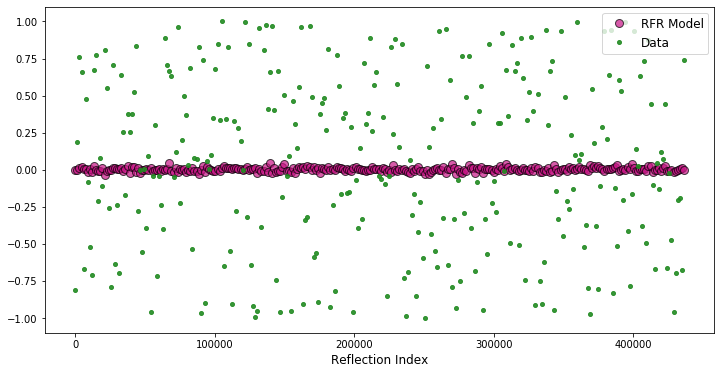

In [329]:
plt.plot(instance_index[::vis_sample], predictions[::vis_sample], 'o', markersize=8, alpha=0.7, color='k', mfc='mediumvioletred', label='RFR Model')
plt.plot(instance_index[::vis_sample], y_train_dnn[::vis_sample], 'o', markersize=4, alpha=0.9, color='forestgreen', label='Data')
plt.xlabel('Reflection Index', fontsize=12)
plt.legend(fontsize=12, loc=1)
plt.show()

### Deep Neural Network (angular loss)

In [55]:
tf.reset_default_graph()

In [56]:
n_hidden1 = 300
n_hidden2 = 100

In [57]:
m, input_length = X_train_dnn.shape

In [58]:
n_outputs=1

In [59]:
with tf.name_scope('placeholders'):
    X = tf.placeholder(tf.float32, shape=(None, input_length), name='X')
    y = tf.placeholder(tf.float32, shape=(None), name='y')

In [60]:
with tf.name_scope('dnn'):
    hidden1 = fully_connected(X, n_hidden1, scope='hidden1')
    hidden2 = fully_connected(hidden1, n_hidden2, scope='hidden2')
    logits = fully_connected(hidden2, n_outputs, activation_fn=None, scope='outputs')

Instructions for updating:
Please use `layer.__call__` method instead.


In [61]:
with tf.name_scope('loss'):
    ang_loss = 2*(1-tf.cos(logits-y*np.pi))
    loss = tf.reduce_mean(ang_loss)

In [62]:
with tf.name_scope('train'):
    optimizer = tf.train.AdagradOptimizer(learning_rate=1e-2)
    training_op = optimizer.minimize(loss)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [63]:
with tf.name_scope('eval'):
    sqrt_mse = tf.sqrt(loss)

In [64]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

#### Training

In [65]:
n_epochs = 200
batch_size = 50

In [66]:
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(m//batch_size):
            X_batch, y_batch = batch_generator(X_train_dnn, y_train.values/180.0, epoch, iteration, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        train_score = sqrt_mse.eval(feed_dict={X: X_batch, y: y_batch})
        print(epoch, 'Train score:', train_score)
    save_path = saver.save(sess, './dnn_angular_loss.ckpt')

0 Train score: 1.3979685
1 Train score: 1.3771684
2 Train score: 1.4486086
3 Train score: 1.4084762
4 Train score: 1.4047309
5 Train score: 1.3827984
6 Train score: 1.3710457
7 Train score: 1.3675677
8 Train score: 1.3774
9 Train score: 1.3657542
10 Train score: 1.3802922
11 Train score: 1.4772935
12 Train score: 1.3652284
13 Train score: 1.3755506
14 Train score: 1.4533124
15 Train score: 1.4482737
16 Train score: 1.4760029
17 Train score: 1.4187659
18 Train score: 1.3972211
19 Train score: 1.471006
20 Train score: 1.4182304
21 Train score: 1.3899572
22 Train score: 1.4018711
23 Train score: 1.4370224
24 Train score: 1.3871504
25 Train score: 1.3898149
26 Train score: 1.3891919
27 Train score: 1.4015868
28 Train score: 1.4037776
29 Train score: 1.4060479
30 Train score: 1.457839
31 Train score: 1.4092596
32 Train score: 1.4953835
33 Train score: 1.4846212
34 Train score: 1.4154204
35 Train score: 1.3571575
36 Train score: 1.4328617
37 Train score: 1.4484428
38 Train score: 1.3365905
3

In [72]:
with tf.Session() as sess:
    saver.restore(sess, './dnn_angular_loss.ckpt')
    predictions = logits.eval(feed_dict={X: X_train_dnn, y: y_train/180.0})

INFO:tensorflow:Restoring parameters from ./dnn_angular_loss.ckpt


In [73]:
instance_index = list(range(y_train_dnn.shape[0]))

In [74]:
vis_sample = 1800

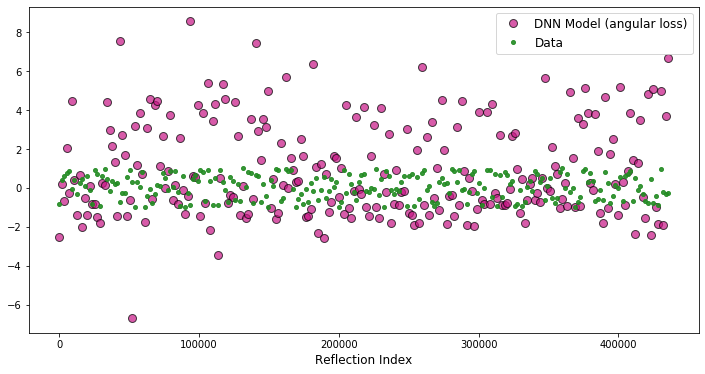

In [75]:
fig = plt.figure(figsize=(12,6))
plt.plot(instance_index[::vis_sample], predictions[::vis_sample], 'o', markersize=8, alpha=0.7, color='k', mfc='mediumvioletred', label='DNN Model (angular loss)')
plt.plot(instance_index[::vis_sample], y_train[::vis_sample]/180.0, 'o', markersize=4, alpha=0.9, color='forestgreen', label='Data')
plt.xlabel('Reflection Index', fontsize=12)
plt.legend(fontsize=12, loc=1)
plt.show()

### Random Regressor (with aproximate distribution inferred from histogram)

In [513]:
from sklearn.base import BaseEstimator

In [514]:
class RandomPhasesRegressor(BaseEstimator):
    
    def __init__(self):
        self.bins_midpoints = None
        self.cdf = None
        
    def fit(self, X, bins='sqrt'):
        hist, bins = np.histogram(X, bins=bins)
        self.bins_midpoints = bins[:-1] + np.diff(bins)/2.0
        cdf = np.cumsum(hist)
        self.cdf = cdf/cdf[-1]
        return None 
    
    def predict(self, X):
        m = len(X)
        values = np.random.rand(m)
        value_bins = np.searchsorted(self.cdf, values)
        sample_from_cdf = self.bins_midpoints[value_bins]
        return sample_from_cdf     

In [515]:
rpr = RandomPhasesRegressor()

In [520]:
rpr.fit(y_train.astype(np.float64),bins='sqrt')

In [521]:
a = rpr.predict(X_train.astype(np.float64))

In [522]:
from sklearn.metrics import mean_squared_error

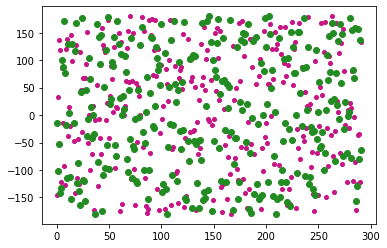

In [527]:
plt.plot(y_train[::vis_sample].values, 'o', color='mediumvioletred', markersize=4)
plt.plot(a[::vis_sample], 'o', color='forestgreen',
         markersize=6)
plt.show()

In [530]:
np.sqrt(mean_squared_error(y_train, a))

147.90999078135664

## Model Evaluation

[**&uarr; Return to Contents**](#Contents)